In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

msa_file = '../urban_greening/msa/michiganMSA_reprojected.shp'
gpp_file = "../urban_greening/nov.15/michigan_test/modis-250-gpp-2015001.tif"
outRas = 'test1.tif'
nlcd_file = "../urban_greening/nov.15/nlcd_2016_land_cover_l48_20210604.img"
ua_file = "../urban_greening/gis_processed/ua/ua_30.tif"


msa=gpd.read_file(msa_file)
msa=msa[msa['NAMELSAD']=='Grand Rapids-Wyoming-Kentwood, MI Metro Area'] # Subsetting to my AOI



with rasterio.open(gpp_file) as gpp_dstrd:
    msa_crsgpp=msa.to_crs(gpp_dstrd.crs)
    msa_crs = msa_crsgpp.crs
    gpp_crs = gpp_dstrd.crs
    gpp_clip_image, gpp_clip_transform=mask(gpp_dstrd,msa_crsgpp.geometry,crop=True)
    

    # replace fillvalue 65535 with np.nan
    gpp_clip_image = np.where(gpp_clip_image == 65535, np.nan, gpp_clip_image) 

    gpp_msa = gpp_clip_image[0]

    from shapely.geometry import mapping
    geometries = [mapping(geom) for geom in msa.geometry]

    with rasterio.open(nlcd_file) as nlcd_dstrd:
        nlcd_crs = nlcd_dstrd.crs
        
        msa_crsr = msa.to_crs(nlcd_crs)
        
        
        
        # Clip the raster using the reprojected geometries
        nlcd_clip_image, nlcd_clip_transform = mask(nlcd_dstrd, geometries, crop=True)
        
        nlcd_msa = nlcd_clip_image[0]

        

        import numpy as np
        gpp_msa_rr = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=np.float32) #make it support nan
        # gpp_msa_rr = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=gpp_dstrd.meta['dtype']), 
        from rasterio.enums import Resampling
        from rasterio.warp import calculate_default_transform, reproject
        reproject(
            source=gpp_msa,
            destination=gpp_msa_rr,
            src_transform=gpp_clip_transform,
            src_crs=gpp_crs,
            dst_transform=nlcd_clip_transform,
            dst_crs=nlcd_crs,
            resampling=Resampling.nearest, # use nearest to prevent unreasonable upscaling
            src_nodata=np.nan
        )
        
       

        with rasterio.open(ua_file) as ua_dstrd:
            ua_crs = ua_dstrd.crs

            ua_clip_image, ua_clip_transform = mask(ua_dstrd, geometries, crop=True)
            ua_msa = ua_clip_image[:][:][0]

            import numpy as np
            ua_msa_rr = np.empty((ua_clip_image.shape[1], ua_clip_image.shape[2]), dtype=ua_dstrd.meta['dtype'])

            from rasterio.enums import Resampling
            from rasterio.warp import calculate_default_transform, reproject
            reproject(
                source=ua_msa,
                destination=ua_msa_rr,
                src_transform=ua_clip_transform,
                src_crs=ua_crs,
                dst_transform=nlcd_clip_transform,
                dst_crs=nlcd_crs,
                resampling=Resampling.nearest
            )

        nee_month_us_file = '../output/nee.tif'
        with rasterio.open(nee_month_us_file) as nee_dstrd:
            nee_crs = gpp_crs
            
            # clip nee raster with shape
            nee_clip_image, nee_clip_transform = mask(nee_dstrd, [mapping(geom) for geom in msa_crsgpp.geometry], crop=True, all_touched=True)  # Include all touched pixels)
            nee_clip_image = np.where(nee_clip_image == -9999, np.nan, nee_clip_image) 
            
            nee_msa = nee_clip_image[0]
            # may not need nee_msa_fine
            # nee_msa_fine = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=np.float32)
            # reproject(
            #     source=nee_msa,
            #     destination=nee_msa_fine,
            #     src_transform=nee_clip_transform,
            #     src_crs=nee_crs,
            #     dst_transform=nlcd_clip_transform,
            #     dst_crs=nlcd_crs,
            #     resampling=Resampling.nearest, # use nearest to prevent unreasonable upscaling
            #     src_nodata=-9999
            # )
        




In [2]:
def save_tiff(output_file, output_path, crs, transform):
    # Write the ndarray to a GeoTIFF
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=output_file.shape[0],
        width=output_file.shape[1],
        count=1,  # Number of bands
        dtype=output_file.dtype,
        crs=crs,
        transform=transform,
        # nodata=np.nan, # do not set this or there will be reprojet edge with value 0
    ) as dst:
        # Write data to the first band
        dst.write(output_file, 1)

    print(f"GeoTIFF saved to {output_path}")

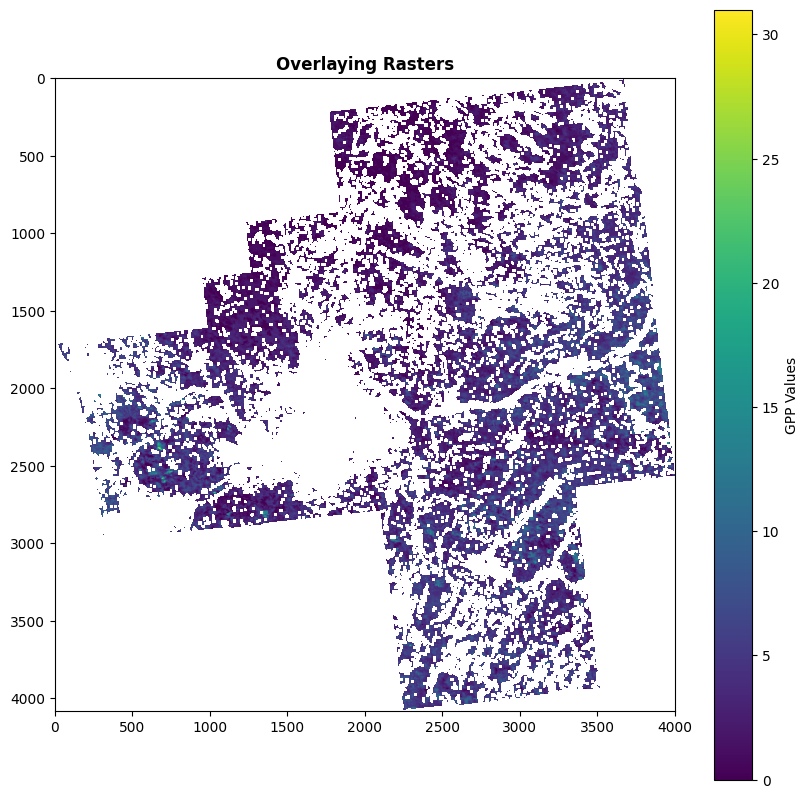

In [12]:
from rasterio import plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
# Show the first raster
rasterio.plot.show(gpp_msa_rr, ax=ax, alpha=0.8, title="Overlaying Rasters")
cax = ax.imshow(gpp_msa_rr, cmap='viridis')  # Use a colormap of your choice
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label("GPP Values")

# Show the second raster as an overlay
# rasterio.plot.show(nlcd_msa, ax=ax, alpha=1)  # Adjust alpha for transparency

# rasterio.plot.show(ua_msa_rr, ax=ax, alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

In [4]:
valid_gpp_mask = ~np.isnan(gpp_msa_rr)
urban_mask = (ua_msa_rr != 0)
suburban_mask = (ua_msa_rr == 0)
forest_mask = (nlcd_msa == 41) | (nlcd_msa == 42) | (nlcd_msa == 43)
shrub_mask = (nlcd_msa == 51) | (nlcd_msa == 52)
grass_mask = (nlcd_msa > 70) & (nlcd_msa < 90)
wetland_mask = (nlcd_msa >= 90) & (nlcd_msa < 100)

# TODO: urban developed, and set to 0 for mean_gpp
nlcd_mask_dict = {
    'urban_forest': urban_mask & forest_mask,
    'suburban_forest': suburban_mask & forest_mask,
    'urban_shrub': urban_mask & shrub_mask,
    'suburban_shrub': suburban_mask & shrub_mask,
    'urban_grass': urban_mask & grass_mask,
    'suburban_grass': suburban_mask & grass_mask,
    'urban_wetland': urban_mask & wetland_mask,
    'suburban_wetland': suburban_mask & wetland_mask,
}

{'name': 'test_msa', 'urban_forest': np.float32(3.259661), 'suburban_forest': np.float32(3.4994838), 'urban_shrub': np.float32(2.8415134), 'suburban_shrub': np.float32(3.856921), 'urban_grass': np.float32(3.4969804), 'suburban_grass': np.float32(3.6307428), 'urban_wetland': np.float32(3.2366927), 'suburban_wetland': np.float32(3.4754617)}


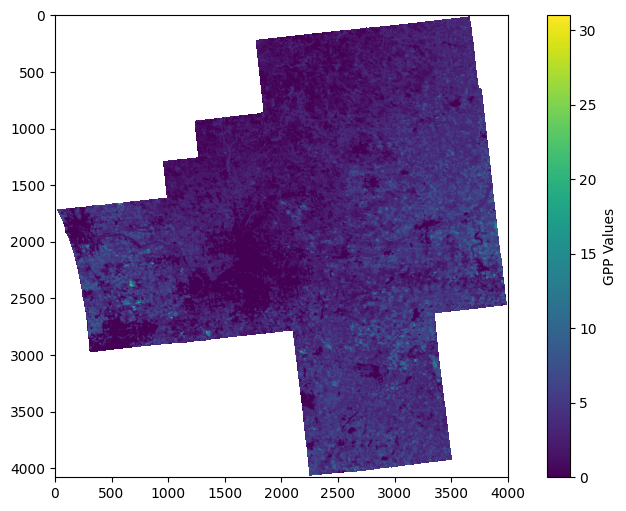

In [7]:
from rasterio.features import geometry_mask
import rasterstats

gpp_msa_rr_filled = np.copy(gpp_msa_rr)

category_gpp_mean_list = []
record = {'name': 'test_msa'}

water_mask = (nlcd_msa > 10) & (nlcd_msa < 20)
developed_mask = (nlcd_msa > 20) & (nlcd_msa < 40)

gpp_msa_rr_filled[~valid_gpp_mask & water_mask] = 0
gpp_msa_rr_filled[~valid_gpp_mask & developed_mask] = 0
# gpp_msa_rr_filled[water_mask] = 0
# gpp_msa_rr_filled[developed_mask] = 0
                  
for category, landcover_mask in nlcd_mask_dict.items():

    category_gpp_mean = np.nanmean(gpp_msa_rr[landcover_mask])
    record[category] = category_gpp_mean
    
    gpp_msa_rr_filled[~valid_gpp_mask & landcover_mask] = category_gpp_mean

print(record)

fig, ax = plt.subplots(figsize=(10, 6)) 
cax = ax.imshow(gpp_msa_rr_filled, cmap='viridis')  # Use a colormap of your choice
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label("GPP Values")
plt.show()

In [13]:
gpp_filled_coarse = np.empty_like(nee_msa, dtype=np.float32)

# Reproject and resample GPP to match NEE's CRS, resolution, and extent
reproject(
    source=gpp_msa_rr_filled,  # Your filled GPP raster
    destination=gpp_filled_coarse,  # Empty array to hold the resampled data
    src_transform=nlcd_clip_transform,  # Transform of the original GPP data
    src_crs=nlcd_crs,  # CRS of the original GPP data
    dst_transform=nee_clip_transform,  # Transform of the clipped NEE data
    dst_crs=nee_crs,  # CRS of the clipped NEE data
    resampling=Resampling.average,  # Use nearest neighbor resampling
    src_nodata=np.nan,  # Set source nodata value
    dst_nodata=np.nan  # Set destination nodata value
)

(array([[       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan, 1.2887918 ,
         1.1677022 , 0.8607327 , 1.185195  , 1.2348713 , 1.9544116 ,
         2.3781168 , 2.923114  , 3.4187443 ],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan, 0.9346466 ,
         0.93766683, 1.1026534 , 1.1135025 , 1.8031455 , 2.2059717 ,
         2.299393  , 2.9178658 , 3.291253  ],
        [       nan,        nan,        nan,        nan,        nan,
                nan, 0.8742075 , 1.3369278 , 1.262286  , 1.2012337 ,
         1.8084432 , 1.2881162 , 1.6599736 , 1.8000907 , 2.37027   ,
         2.8326235 , 3.1081681 , 3.6570766 ],
        [       nan,        nan,        nan,        nan,        nan,
         1.2201815 , 1.0081563 , 1.3383336 , 1.480774  , 1.299347  ,
         1.4061735 , 2.1305182 , 2.1708224 , 2.4903076 , 3.8344533 ,
         3.6405406 , 4.0195146 , 4

In [21]:
save_tiff(gpp_msa_rr_filled, '../output/gpp_msa_rr_filled2.tif', nlcd_crs, nlcd_clip_transform)
save_tiff(gpp_filled_coarse, '../output/gpp_filled_coarse2.tif', nee_crs, nee_clip_transform)

# save_tiff(nee_msa, '../output/nee_msa2.tif', nee_crs, nee_clip_transform)

GeoTIFF saved to ../output/gpp_msa_rr_filled2.tif
GeoTIFF saved to ../output/gpp_filled_coarse2.tif


In [24]:

save_tiff(nee_msa / gpp_filled_coarse, '../output/nee_gpp_ration.tif', nee_crs, nee_clip_transform)

GeoTIFF saved to ../output/nee_gpp_ration.tif


array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.49191988,
        0.28306806, 0.2654339 , 0.26880965, 0.21462004, 0.12548396,
        0.09870747, 0.10303751, 0.09009015],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.5858102 ,
        0.23394373, 0.19835636, 0.21573511, 0.15474108, 0.1183041 ,
        0.07746892, 0.09054477, 0.09184484],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.3997462 , 0.3135832 , 0.29176286, 0.25118446,
        0.16989455, 0.21940967, 0.16249569, 0.15096655, 0.12719242,
        0.09727192, 0.09562586, 0.08524881],
       [       nan,        nan,        nan,        nan,        nan,
        0.31597614, 0.3510907 , 0.329143  , 0.2258312 , 0.24098128,
        0.25506815, 0.15052047, 0.13706754, 0.08555823, 0.07264339,
        0.06847282, 0.06574544, 0.06707919],
    

In [26]:
nee_gpp_ratio_fine = np.empty_like(gpp_msa_rr_filled, dtype=np.float32)

# Reproject and resample GPP to match NEE's CRS, resolution, and extent
reproject(
    source=nee_msa / gpp_filled_coarse,  # Your filled GPP raster
    destination=nee_gpp_ratio_fine,  # Empty array to hold the resampled data
    src_transform=nee_clip_transform,  # Transform of the original GPP data
    src_crs=nee_crs,  # CRS of the original GPP data
    dst_transform=nlcd_clip_transform,  # Transform of the clipped NEE data
    dst_crs=nlcd_crs,  # CRS of the clipped NEE data
    resampling=Resampling.nearest,  # Use nearest neighbor resampling
    src_nodata=np.nan,  # Set source nodata value
    dst_nodata=np.nan  # Set destination nodata value
)


(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 Affine(30.0, 0.0, 786105.0,
        0.0, -30.0, 2327445.0))

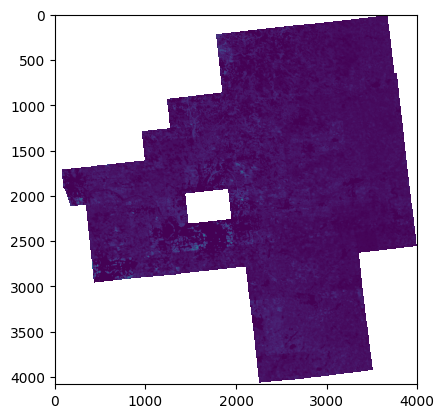

<Axes: >

In [ ]:

rasterio.plot.show()

In [32]:
save_tiff(nee_gpp_ratio_fine * gpp_msa_rr_filled, '../output/downscaled_nee.tif', nlcd_crs, nlcd_clip_transform)

GeoTIFF saved to ../output/downscaled_nee.tif


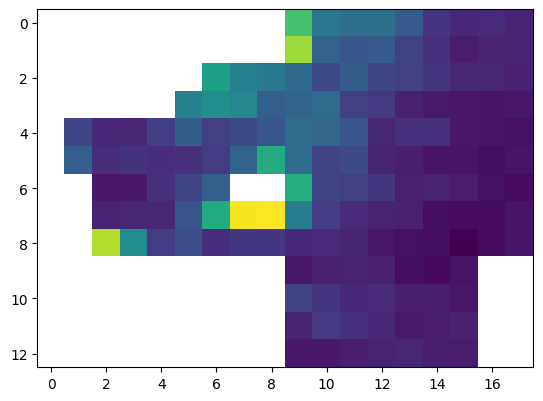

<Axes: >

In [28]:
rasterio.plot.show(nee_msa / gpp_filled_coarse)

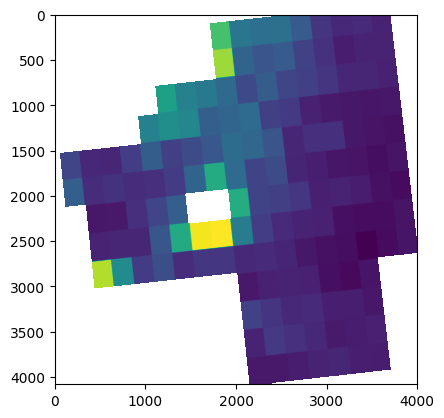

<Axes: >

In [27]:
rasterio.plot.show(nee_gpp_ratio_fine)

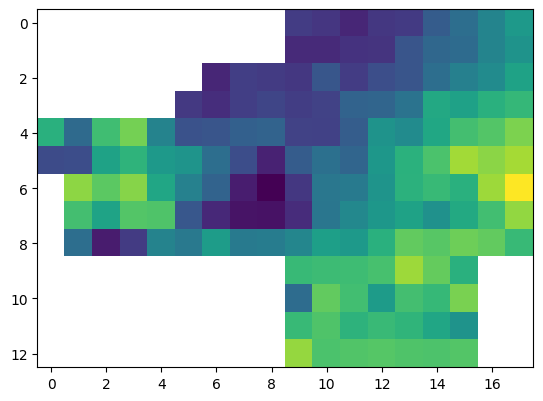

<Axes: >

In [18]:
rasterio.plot.show(gpp_filled_coarse)

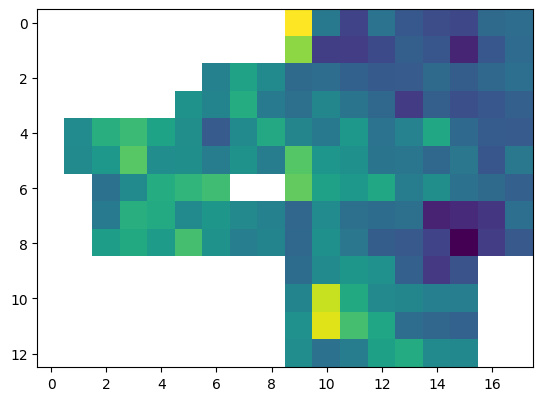

<Axes: >

In [19]:
rasterio.plot.show(nee_msa)